In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import email as em

from datetime import date, timedelta, datetime
from time import mktime
from email.utils import parsedate, parsedate_tz
from email.parser import HeaderParser

from classes.gmail import GmailAccount

In [ ]:
password = open(os.path.expanduser('~/.ssh/pw'), 'r').read().strip()

In [ ]:
tyler = GmailAccount(username='tyleha@gmail.com', password=password)
tyler.login()

In [ ]:
daysback = 2
notsince = 0
since = (date.today() - timedelta(daysback)).strftime("%d-%b-%Y")
before = (date.today() - timedelta(notsince)).strftime("%d-%b-%Y")

SEARCH = '(SENTSINCE {si} SENTBEFORE {bf})'.format(si=since, bf=before)
BODY = '(BODY.PEEK[TEXT])'
ALL_HEADERS = '(BODY.PEEK[HEADER.FIELDS (DATE TO CC FROM SUBJECT)])'
DATE = '(BODY.PEEK[HEADER.FIELDS (DATE)])'

In [ ]:
#LOAD GMAIL EMAILS
received = tyler.load_parse_query(SEARCH, 'RFC822', '"[Gmail]/All Mail"')
# sent = tyler.load_parse_query(SEARCH, ALL_HEADERS, '[Gmail]/Sent Mail')

In [3]:
def load_pickle(filepath, ftype='r'):
    """opens and closes pickled file and returns contained pickleobj"""
    f = open(filepath, ftype)
    contents = pickle.load(f)
    f.close()
    return contents    

def save_pickle(content, filepath, ftype='w'):
    """
    :return: pickle's weird dump output. not useful
    :content: the object to be saved (can be any type)
    :filepath: the string path, relative or not, at which to save
    :ftype: 'w' to write, 'wb' to write binary
    """
    f = open(filepath, ftype)
    xx = pickle.dump(content, f)
    f.close()
    return xx

# Do the pandas thing

In [5]:
import pandas as pd
import numpy as np
import pickle

In [2]:
def scrub_email(headers):    
    d = {}
    for val in headers:
        d[val[0].lower()] = val[1]
    return d

def try_parse_date(d):
    # Sometimes, IMAP just has dates formatted in a totally improper 
    # way...see 'Thursday , 10 Dec 2009 16:28:55, PST'
    try:
        return pd.Timestamp(datetime.fromtimestamp(mktime(parsedate(d))))
    except:
        return np.nan

In [6]:
received = load_pickle('/home/tyleha/git/all_emails', 'rb')

In [67]:
# Frequency
freq = 'M'

df = pd.DataFrame([scrub_email(email._headers) for email in received])
 
# This might take a minute...
df['timestamp'] = df.date.map(lambda x: pd.to_datetime(x, errors='coerce'))
df = df.dropna(subset=['timestamp'])

In [68]:
# Now we're off to the races
df['hour'] = df.timestamp.map(lambda x: x.hour)
df = df.set_index('timestamp', drop=False)
df.index = df.index.to_period(freq)


In [71]:
# Scale our heatmap to the min/max range of our email data.
mindate = df.timestamp.min()
maxdate = df.timestamp.max()
pr = pd.period_range(mindate, maxdate, freq=freq)

# Initialize a new HeatMap dataframe where the indicies are actually Periods of time!
# Size the frame anticipating the correct number of rows (periods) and columns (hours in a day)
hm = pd.DataFrame(np.zeros([len(pr), 24]) , index=pr)

from classes.progress import ProgressBar

prog = ProgressBar(len(pr))
for i, period in enumerate(pr):
    # HERE'S where the magic happens...with pandas, when you structure your data correctly, it can be so terse that
    # you almost aren't sure the program does what it says it does...
    # For this period (month), find all emails within this month and count how many emails were received
    # within each hour of the day in that month. Wow. Takes more words to explain than to code.
    # Normally that would take you 3 or 4 for loops, constantly trying to catch edge cases and fencepost
    # problems. But here, it's as simple as you please.
    hm.ix[period] = df.loc[period].hour.value_counts()
    prog.animate(i)
    
# If for some weird reason there was ever an hour period where you received no email,
# fill those NaNs with zeros.
hm.fillna(0, inplace=True)

 117 of 117    [##################### 100% #####################]    Time: 0:00:01    ETA: ...

# Heatmap Plot

In [72]:
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import time
%matplotlib inline

(0, 23)

/home/tyleha/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


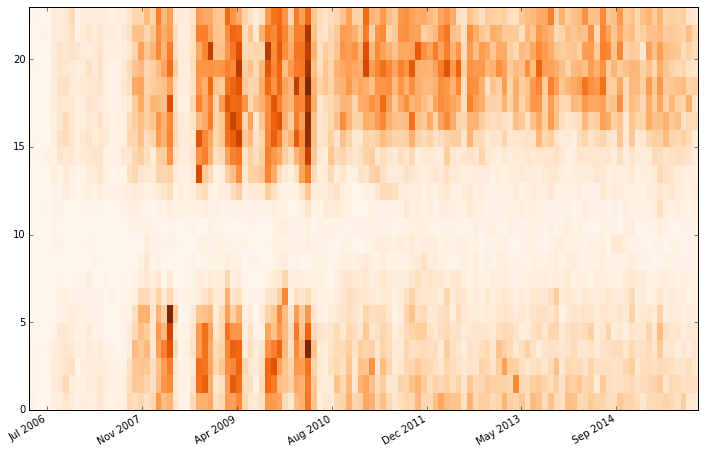

In [73]:
# fig = plt.figure(figsize=(12,8))
# ax = fig.add_subplot()
fig, ax = plt.subplots(figsize=(12, 8))

# ai = plt.imshow(hm.transpose(), interpolation='nearest', cmap='Oranges')
# x = np.array([time.mktime(x.start_time.timetuple()) for x in pr])
x = dates.date2num([p.start_time for p in pr])
y = np.arange(24)
plt.pcolor(x, y, hm.transpose().as_matrix(), cmap='Oranges')

date_format = dates.DateFormatter('%b %Y')
ax.xaxis.set_major_formatter(date_format)
# ax.xaxis.set_major_locator(months)
fig.autofmt_xdate()

ax.set_xlim([dates.date2num(pr[0].start_time), dates.date2num(pr[-1].start_time)])
ax.set_ylim([0, 23])

In [ ]:
df.tail()

In [ ]:
x = pr[0]
x.start_time.

# Scratch City

In [ ]:
pd.crosstab()

In [ ]:
ax = plt.imshow(hm.transpose(), interpolation='nearest', cmap='Oranges').axes

In [ ]:
dates.date2num()